In [1]:
import torch
import torchvision
import numpy as np
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from functools import partial
import cv2
%matplotlib inline

In [2]:
image_size = (224, 224)

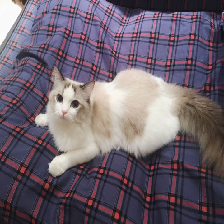

In [3]:
image = Image.open('./data/test.jpg').convert('RGB').resize(image_size)
image

In [4]:
model = models.resnet18(pretrained=True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [6]:
input_image = preprocess(image).unsqueeze(0)
features = [None]
def hook(module, inputs, outputs, features):
    features[0] = inputs
model.avgpool.register_forward_hook(partial(hook, features=features))
with torch.no_grad():
    out = model(input_image)
_, pred_class = torch.max(out, 1)
feature_map = features[0][0]

In [7]:
num_channels = model.fc.weight[pred_class, :].shape[1]

In [8]:
w = model.fc.weight[pred_class, :].view(1, num_channels, 1, 1)
#### Compute CAM ####
cam = torch.mean(w * feature_map, (0, 1)).detach().numpy()
cam = cam - np.min(cam)
cam_image = cam / np.max(cam)
cam_image = np.uint8(cam_image * 255)

In [9]:
heatmap = cv2.applyColorMap(cv2.resize(cam_image,image_size), cv2.COLORMAP_JET)

In [10]:
img = np.array(image)

In [11]:
out = img * 0.7 + heatmap * 0.3

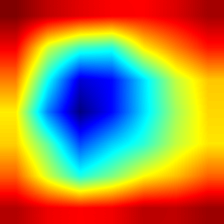

In [12]:
Image.fromarray(heatmap)

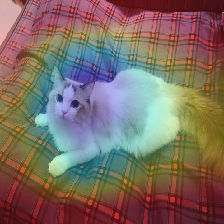

In [13]:
Image.fromarray(out.astype(np.uint8))